# ПРОЕКТ: Прогнозирование оттока телеком компании

<font><b>Описание задачи:</b></font> в проекте необходимо проанализировать отток клиентов, заказчик - оператор связи. Нужно построить модель, которая поможет предсказать уход клиента.

<font><b>Описание полей данных:</b></font><br>
BeginDate – дата начала пользования услугами,<br>
EndDate – дата окончания пользования услугами,<br>
Type – тип договора: ежемесячный, годовой и т.д,<br>
PaperlessBilling – факт выставления счёта на электронную почту,<br>
PaymentMethod – способ оплаты,<br>
MonthlyCharges – ежемесячные траты на услуги,<br>
TotalCharges – всего потрачено денег на услуги,<br>
Dependents – наличие иждивенцев,<br>
Senior Citizen – наличие пенсионного статуса по возрасту,<br>
Partner – наличие супруга(и),<br>
MultipleLines – наличие возможности ведения параллельных линий во время звонка.

## Открываем файлы с данными и изучаем общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
STATE = np.random.RandomState(100423)

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
contract.info()
contract.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
display(contract.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [7]:
personal.info()
personal.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
display(personal.head(10))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [9]:
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7693-LCKZL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [10]:
display(internet.head(10))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [11]:
phone.info()
phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7016-NVRIC,No
freq,1,3390


In [12]:
display(phone.head(10))

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


В двух из 4-х датасетов количество строк совпадает и равно 7043. В остальных датасетах данных меньше - 5517 и 6361. Проверим данные на явные дубликаты.

In [13]:
contract.duplicated().sum()

0

In [14]:
personal.duplicated().sum()

0

In [15]:
internet.duplicated().sum()

0

In [16]:
phone.duplicated().sum()

0

Явных дубликатов в данных не обнаружено. В каждой таблице есть общий столбец - customerID, по которому позже можно будет объединить таблицы. Пропусков в данных нет. Каких-то аномалий в данных тоже не видно.

## Подготовка данных 

In [17]:
# приведем к нижнему регистру названия столбцов в датасетах 
contract.columns = contract.columns.str.lower()
personal.columns = personal.columns.str.lower()
internet.columns = internet.columns.str.lower()
phone.columns = phone.columns.str.lower()

In [18]:
# Для дальнейших преобразований заменим в столбце enddate значение No на 1 февраля 2020 г
contract['enddate'] = contract['enddate'].replace('No', '2020-02-01', regex=True)

In [19]:
# приведем временные даты к формату времени
contract['begindate'] = pd.to_datetime(contract['begindate'], format = '%Y-%m-%d')
contract['enddate'] = pd.to_datetime(contract['enddate'], format = '%Y-%m-%d')

Создадим дополнительный признак в датасете - количество дней по контракту, которые клиент пользовался услугами

In [20]:
contract['days'] = contract['enddate'] - contract['begindate']

In [21]:
contract['days'].dt.days

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: days, Length: 7043, dtype: int64

In [22]:
# в столбце TotalCharges тип данных - object. Посмотрим, из-за чего и исправим на float
contract['totalcharges'].unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [23]:
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce')

В целом данные в приличном виде, очищать или заполнять пропуски в отдельных таблицах не надо. Теперь посмотрим на корреляцию между данными. Сначала приведем наш целевой признак EndDate к бинарному типу, где 1 - клиент ушел, 0 - клиент действущий, добавим признак в новый столбец target

In [24]:
# Посмотрим на данные в столбце EndDate
contract['enddate'].unique()

array(['2020-02-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-02-01

In [25]:
contract['target'] = contract['enddate']
contract['target'].loc[contract['enddate'] != '2020-02-01T00:00:00.000000000'] = 1
contract['target'].loc[contract['target'] != 1] = 0    

In [26]:
display(contract.head(10))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31 days,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036 days,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123 days,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371 days,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153 days,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,337 days,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671 days,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,306 days,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,945 days,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,882 days,1


Объединим все таблицы в одну для дальнейшей работы

In [27]:
data_1 = pd.merge(contract, personal, how='left', on='customerid')

In [28]:
data_2 = pd.merge(data_1, internet, how='left', on='customerid')

In [29]:
data_all = pd.merge(data_2, phone, how='left', on='customerid')
display(data_all.head(10))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,target,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31 days,0,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036 days,0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123 days,0,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371 days,0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153 days,0,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,337 days,0,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,671 days,0,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,306 days,0,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,945 days,0,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,882 days,1,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [30]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerid        7043 non-null   object         
 1   begindate         7043 non-null   datetime64[ns] 
 2   enddate           7043 non-null   datetime64[ns] 
 3   type              7043 non-null   object         
 4   paperlessbilling  7043 non-null   object         
 5   paymentmethod     7043 non-null   object         
 6   monthlycharges    7043 non-null   float64        
 7   totalcharges      7032 non-null   float64        
 8   days              7043 non-null   timedelta64[ns]
 9   target            7043 non-null   object         
 10  gender            7043 non-null   object         
 11  seniorcitizen     7043 non-null   int64          
 12  partner           7043 non-null   object         
 13  dependents        7043 non-null   object         
 14  internet

In [31]:
data_all['target'] = data_all['target'].astype('int64')
data_all['days'] = data_all['days'].astype('int64')

Посмотрим на корреляцию между целевым признаком и числовыми столбцами

In [32]:
data_all.corr()

,monthlycharges,totalcharges,days,target,seniorcitizen
monthlycharges,1.000000,0.630297,0.220054,0.154286,0.220173
totalcharges,0.630297,1.000000,0.821442,0.051548,0.093383
days,0.220054,0.821442,1.000000,0.016578,0.005283
target,0.154286,0.051548,0.016578,1.000000,0.056724
seniorcitizen,0.220173,0.093383,0.005283,0.056724,1.000000


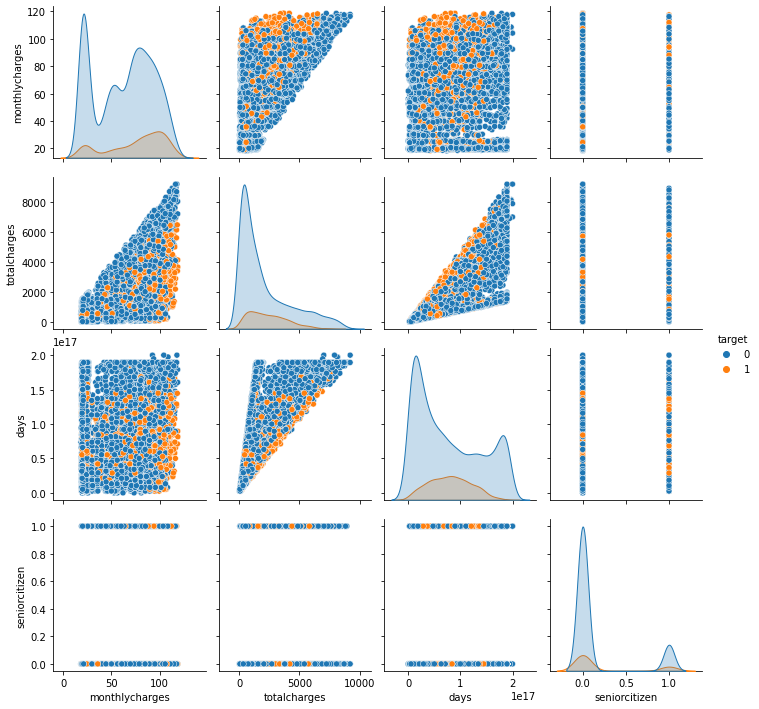

In [33]:
sns.pairplot(data_all, hue='target')

Чтение графиков не моя сильная сторона, но я пробую: видно, что число ушедших клиентов довольно небольшое по сравнению с действующими. Также можно сказать, что ушедшие клиенты тратила гораздо меньшие суммы на услуги, чем действующие клиенты. Среди клиентов непенсионного возраста действующих клиентов гораздо больше, чем ушедших. <br>
При этом цифры явно показывают, что прослеживается корреляция, пусть и не сильная, между monthlycharges и totalcharges. При это корреляция между целевым признаком и обоими столбцами с инфрмацией об оплате еще меньше, можно сказать, что почти нет.

Теперь посмотрим на корреляцию между целевым признаком и категориальными признаками

In [34]:
pd.pivot_table(data_all, index=['type', 'paperlessbilling', 'paymentmethod'], values='target',\
               aggfunc ='count')

target
type           paperlessbilling paymentmethod                    
Month-to-month No               Bank transfer (automatic)     206
                                Credit card (automatic)       161
                                Electronic check              453
                                Mailed check                  469
               Yes              Bank transfer (automatic)     383
                                Credit card (automatic)       382
                                Electronic check             1397
                                Mailed check                  424
One year       No               Bank transfer (automatic)     171
                                Credit card (automatic)       174
                                Electronic check              114
                                Mailed check                  214
               Yes              Bank transfer (automatic)     220
                                Credit card (automatic)       224
                                Electronic check              233
                                Mailed check                  123
Two year       No               Bank transfer (automatic)     276
                                Credit card (automatic)       305
                                Electronic check               56
                                Mailed check                  273
               Yes              Bank transfer (automatic)     288
                                Credit card (automatic)       276
                                Electronic check              112
                                Mailed check                  109

В целом можно сказать, что: 
1. У большей части ушедших клиентов тип договора был ежемесячный, в годовом и двухгодичном договоре цифры примерно одинаковые.
2. Среди тех, кому выставляли счёта на электронную почту, больше ушедших.
3. Резко выделяется число ушедших клиентов среди тех, у кого был ежемесячный договор с выставлением счёта на электронную почту и электронным чеком. 

#### Дальнейший план действий: 
1. Проанализировать данные в остальных таблицах. 
2. Объединить таблицы, заполнить пропуски, разделить данные на выборки и закодировать их. 
3. Обучить 3 разных модели, добиться необходимых значений метрик путем подбора гиперпараметров и/или работы с данными, возможно добавлением новых данных на основе уже имеющихся данных. 
4. Проверить лучшую модель на тестовой выборке
5. Сделать выводы и написать отчет по проделанной работе. 

In [35]:
pd.pivot_table(data_all, index=['gender', 'seniorcitizen', 'partner', 'dependents'], values='target',\
               aggfunc ='count')

target
gender seniorcitizen partner dependents        
Female 0             No      No            1338
                             Yes            142
                     Yes     No             596
                             Yes            844
       1             No      No             317
                             Yes              3
                     Yes     No             209
                             Yes             39
Male   0             No      No            1381
                             Yes            211
                     Yes     No             567
                             Yes            822
       1             No      No             244
                             Yes              5
                     Yes     No             281
                             Yes             44

Что касается персональных данных клиентов, то пока кажется, что каких-то закономерностей нет, всё довольно ровно. Нужны ли они для обучения моделей, пока непонятно

In [36]:
pd.pivot_table(data_all, index=['internetservice', 'onlinesecurity', 'onlinebackup', \
                                'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'], \
               values='target', aggfunc ='count')

target
internetservice onlinesecurity onlinebackup deviceprotection techsupport streamingtv streamingmovies        
DSL             No             No           No               No          No          No                  294
                                                                                     Yes                  47
                                                                         Yes         No                   41
                                                                                     Yes                  37
                                                             Yes         No          No                   74
...                                                                                                      ...
Fiber optic     Yes            Yes          Yes              No          Yes         Yes                  64
                                                             Yes         No          No                   18
                                                                                     Yes                  17
                                                                         Yes         No                   15
                                                                                     Yes                 141

[128 rows x 1 columns]

В данных по интернету несколько выделяются ушедшие клиенты, которые не пользовались никакими сервисами с технологией интернета DSL. Но и много отсутствующих данных. 

Удалим неинформативные столбцы

In [37]:
data_all = data_all.drop(['customerid', 'begindate', 'enddate'], axis=1)

In [38]:
# Посмотрим на пропуски в датасете
data_all.isna().sum().sort_values(ascending=False)

streamingmovies     1526
streamingtv         1526
techsupport         1526
deviceprotection    1526
onlinebackup        1526
onlinesecurity      1526
internetservice     1526
multiplelines        682
totalcharges          11
dependents             0
type                   0
paperlessbilling       0
seniorcitizen          0
gender                 0
target                 0
days                   0
monthlycharges         0
paymentmethod          0
partner                0
dtype: int64

In [39]:
# Заменим пропуски во всех столбцах, появившиеся после объединения, на unknown 
for column in ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', \
          'streamingtv', 'streamingmovies', 'multiplelines']:
    data_all[column] = data_all[column].fillna('unknown')

In [41]:
data_all['totalcharges'] = data_all['totalcharges'].fillna(0)

In [42]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7043 non-null   object 
 1   paperlessbilling  7043 non-null   object 
 2   paymentmethod     7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   days              7043 non-null   int64  
 6   target            7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   seniorcitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetservice   7043 non-null   object 
 12  onlinesecurity    7043 non-null   object 
 13  onlinebackup      7043 non-null   object 
 14  deviceprotection  7043 non-null   object 
 15  techsupport       7043 non-null   object 
 16  streamingtv       7043 non-null   object 


Далее воспользуемся техникой OHE для кодирования категориальных признаков и StandardScaler для числовых признаков, но сначала разделим данные на тренировочную и тестовую выборки.

In [43]:
features = data_all.drop(['target'], axis=1)
target = data_all['target']

In [45]:
# Разделим данные на тренировочную и тестовую выборки в соотношении 75:25
features_train, features_test, target_train, target_test = \
train_test_split(features, target, stratify=target, test_size=0.25, random_state=STATE)

In [46]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['type',
 'paperlessbilling',
 'paymentmethod',
 'gender',
 'partner',
 'dependents',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'multiplelines']

In [47]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('seniorcitizen')
num_features

['monthlycharges', 'totalcharges', 'days']

In [48]:
sc = StandardScaler()
features_train[num_features] = sc.fit_transform(features_train[num_features])
features_test[num_features]= sc.transform(features_test[num_features])

In [49]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(features_train[ohe_features])
features_train_ohe = pd.DataFrame(ohe.transform(features_train[ohe_features]), 
                              columns=ohe.get_feature_names(ohe_features), index=features_train.index)

In [50]:
ohe.fit(features_test[ohe_features])
features_test_ohe = pd.DataFrame(ohe.transform(features_test[ohe_features]), 
                              columns=ohe.get_feature_names(ohe_features), index=features_test.index)

In [51]:
features_train_1 = features_train.loc[:,num_features].merge(features_train_ohe, left_index=True, right_index=True)
features_test_1 = features_test.loc[:,num_features].merge(features_test_ohe, left_index=True, right_index=True)

In [52]:
features_train_1

,monthlycharges,totalcharges,days,type_Month-to-month,type_One year,type_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),...,techsupport_unknown,streamingtv_No,streamingtv_Yes,streamingtv_unknown,streamingmovies_No,streamingmovies_Yes,streamingmovies_unknown,multiplelines_No,multiplelines_Yes,multiplelines_unknown
1280,1.679263,3.198059,1.916274,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
838,0.495950,0.368914,0.301478,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1958,0.683488,-0.142630,-0.371845,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
725,-1.427556,-0.903524,-0.905200,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4345,-1.450790,-0.269226,1.785145,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,-0.144665,-0.622506,-0.728397,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6762,-0.307308,0.031089,0.437026,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4915,-0.831750,-0.549464,-0.323225,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5127,1.795437,0.640594,-0.099275,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [53]:
features_test_1

,monthlycharges,totalcharges,days,type_Month-to-month,type_One year,type_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),...,techsupport_unknown,streamingtv_No,streamingtv_Yes,streamingtv_unknown,streamingmovies_No,streamingmovies_Yes,streamingmovies_unknown,multiplelines_No,multiplelines_Yes,multiplelines_unknown
4261,-0.318926,0.495131,1.247371,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
276,1.353977,0.938708,0.347152,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2043,0.178962,-0.456588,-0.592849,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6692,0.344924,0.527675,0.526901,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1712,-0.299010,-0.228545,-0.010874,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5165,0.178962,-0.813428,-1.086422,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6629,0.658594,1.901607,1.916274,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3579,0.562335,0.558730,0.482700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
298,0.341605,-0.022497,-0.100748,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [54]:
features_train.columns

Index(['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'days', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'multiplelines'],
      dtype='object')

In [55]:
# Кодирование категориальных признаков для леса и lgbm
enc = OrdinalEncoder()
enc.fit(features_train[ohe_features])
features_train[ohe_features] = enc.transform(features_train[ohe_features])

In [56]:
enc.fit(features_test[ohe_features])
features_test[ohe_features] = enc.transform(features_test[ohe_features])

In [57]:
features_train_2 = features_train.loc[:,num_features].merge(features_train[ohe_features], left_index=True, right_index=True)
features_test_2 = features_test.loc[:,num_features].merge(features_test[ohe_features], left_index=True, right_index=True)

In [58]:
features_train_2

,monthlycharges,totalcharges,days,type,paperlessbilling,paymentmethod,gender,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
1280,1.679263,3.198059,1.916274,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
838,0.495950,0.368914,0.301478,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1958,0.683488,-0.142630,-0.371845,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
725,-1.427556,-0.903524,-0.905200,0.0,1.0,3.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
4345,-1.450790,-0.269226,1.785145,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,-0.144665,-0.622506,-0.728397,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6762,-0.307308,0.031089,0.437026,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4915,-0.831750,-0.549464,-0.323225,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
5127,1.795437,0.640594,-0.099275,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [59]:
features_test_2

,monthlycharges,totalcharges,days,type,paperlessbilling,paymentmethod,gender,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
4261,-0.318926,0.495131,1.247371,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
276,1.353977,0.938708,0.347152,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2043,0.178962,-0.456588,-0.592849,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6692,0.344924,0.527675,0.526901,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1712,-0.299010,-0.228545,-0.010874,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5165,0.178962,-0.813428,-1.086422,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6629,0.658594,1.901607,1.916274,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3579,0.562335,0.558730,0.482700,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
298,0.341605,-0.022497,-0.100748,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


Изучили и подготовили данные для дальнейшей работы с ними. Подготовили выборки для обучения моделей.

## Обучение моделей

In [60]:
%%time
# Обучение модели логистической регрессии

logistic = LogisticRegression(class_weight='balanced', random_state=STATE)

param_grid = {'C': np.logspace(0.01, 50, 10)}
grid_log = GridSearchCV(
    logistic, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10
)
grid_log.fit(features_train_1, target_train)
print(grid_log.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START C=1.023292992280754........................................
[CV 1/3; 1/10] END ......................C=1.023292992280754; total time=   0.8s
[CV 2/3; 1/10] START C=1.023292992280754........................................
[CV 2/3; 1/10] END ......................C=1.023292992280754; total time=   1.6s
[CV 3/3; 1/10] START C=1.023292992280754........................................
[CV 3/3; 1/10] END ......................C=1.023292992280754; total time=   1.2s
[CV 1/3; 2/10] START C=366812.76823930326.......................................
[CV 1/3; 2/10] END .....................C=366812.76823930326; total time=   1.1s
[CV 2/3; 2/10] START C=366812.76823930326.......................................
[CV 2/3; 2/10] END .....................C=366812.76823930326; total time=   1.2s
[CV 3/3; 2/10] START C=366812.76823930326.......................................
[CV 3/3; 2/10] END .....................C=366812

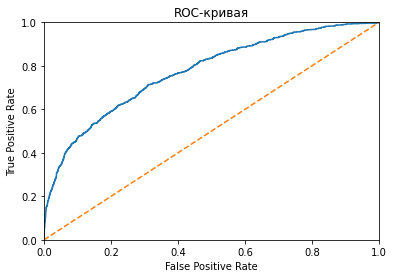

In [61]:
prob = grid_log.predict_proba(features_train_1)
prob_one = prob[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, prob_one)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [63]:
pred_train = grid_log.predict(features_train_1)
f1 = f1_score(target_train, pred_train)
f1

0.4197080291970803

In [64]:
%%time
# Обучение модели случайного леса

forest = RandomForestClassifier(class_weight='balanced', random_state=STATE)
# pipe_forest = Pipeline([
#     ('forest', forest)
# ])
param_grid = {'n_estimators':range(10, 151, 10), \
              'max_depth': range(5, 15)}

grid_forest = GridSearchCV(
    forest, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10
)
grid_forest.fit(features_train_2, target_train)
print(grid_forest.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV 1/3; 1/150] START max_depth=5, n_estimators=10..............................
[CV 1/3; 1/150] END ............max_depth=5, n_estimators=10; total time=   0.1s
[CV 2/3; 1/150] START max_depth=5, n_estimators=10..............................
[CV 2/3; 1/150] END ............max_depth=5, n_estimators=10; total time=   0.0s
[CV 3/3; 1/150] START max_depth=5, n_estimators=10..............................
[CV 3/3; 1/150] END ............max_depth=5, n_estimators=10; total time=   0.1s
[CV 1/3; 2/150] START max_depth=5, n_estimators=20..............................
[CV 1/3; 2/150] END ............max_depth=5, n_estimators=20; total time=   0.1s
[CV 2/3; 2/150] START max_depth=5, n_estimators=20..............................
[CV 2/3; 2/150] END ............max_depth=5, n_estimators=20; total time=   0.1s
[CV 3/3; 2/150] START max_depth=5, n_estimators=20..............................
[CV 3/3; 2/150] END ............max_depth=5, n

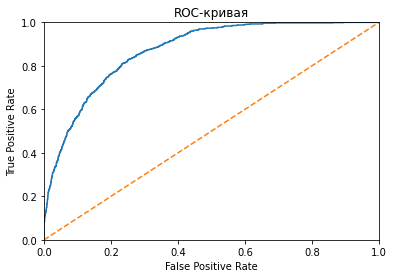

In [65]:
prob = grid_forest.predict_proba(features_train_2)
prob_one = prob[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, prob_one)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [66]:
pred_train = grid_forest.predict(features_train_2)
f1 = f1_score(target_train, pred_train)
f1

0.5203190277250285

In [67]:
%%time
# Обучение модели LGBM

lgbm = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', random_state=STATE) 
# pipe_lgbm = Pipeline([
#     ('lgbm', lgbm)
# ])
param_grid = {'max_depth': [2, 6, 12],
             'n_estimators': [20, 50, 100]}

grid_lgbm = GridSearchCV(
    lgbm, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10
)
grid_lgbm.fit(features_train_2, target_train)
print(grid_lgbm.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START max_depth=2, n_estimators=20................................
[CV 1/3; 1/9] END ..............max_depth=2, n_estimators=20; total time=   9.3s
[CV 2/3; 1/9] START max_depth=2, n_estimators=20................................
[CV 2/3; 1/9] END ..............max_depth=2, n_estimators=20; total time=  10.1s
[CV 3/3; 1/9] START max_depth=2, n_estimators=20................................
[CV 3/3; 1/9] END ..............max_depth=2, n_estimators=20; total time=  10.1s
[CV 1/3; 2/9] START max_depth=2, n_estimators=50................................
[CV 1/3; 2/9] END ..............max_depth=2, n_estimators=50; total time=  21.9s
[CV 2/3; 2/9] START max_depth=2, n_estimators=50................................
[CV 2/3; 2/9] END ..............max_depth=2, n_estimators=50; total time=  24.1s
[CV 3/3; 2/9] START max_depth=2, n_estimators=50................................
[CV 3/3; 2/9] END ..............max_depth=2, n_es

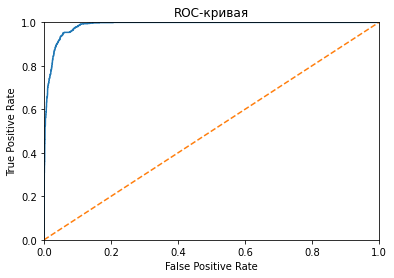

In [68]:
prob = grid_lgbm.predict_proba(features_train_2)
prob_one = prob[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, prob_one)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [70]:
pred_train = grid_lgbm.predict(features_train_2)
f1 = f1_score(target_train, pred_train)
f1

0.7831558567279768

Я обучила 3 модели: линейная регрессия, случайный лес и lightGBM. Лучшую метрику auc_roc на трейне показала модель lightGBM, auc_roc получилась равной 0.85. Чуть хуже показатель у случайного леса, здесь метрика auc_roc = 0.82. Линейная регрессия же показала худший результат, равный 0.76. Вспомогательная метрика f1 показала такие результаты: линейная регрессия - 0.41, случайный лес - 0.51, lightGBM - 0.78.Проверим теперь модель lightGBM на тестовой выборке. 

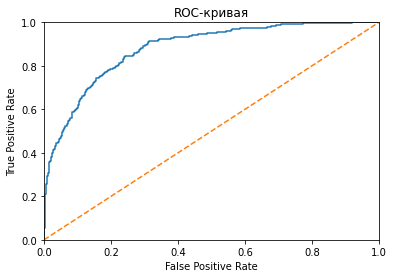

0.879914352135079


In [71]:
prob = grid_lgbm.predict_proba(features_test_2)
prob_one = prob[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, prob_one)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, prob_one)
print(auc_roc)

На тестовой выборке удалось достичь необходимого значения метрики AUC-ROC >= 0.85. Она получилась равной 0.87

In [72]:
# Посмотрим на качество ответов модели через матрицу ошибок
confusion_matrix(target_test, prob_one.round())

array([[1295,  191],
       [  84,  191]])

In [73]:
target_test.value_counts()

0    1486
1     275
Name: target, dtype: int64

Посмотрим, какие признаки оказались наиболее важными в модели

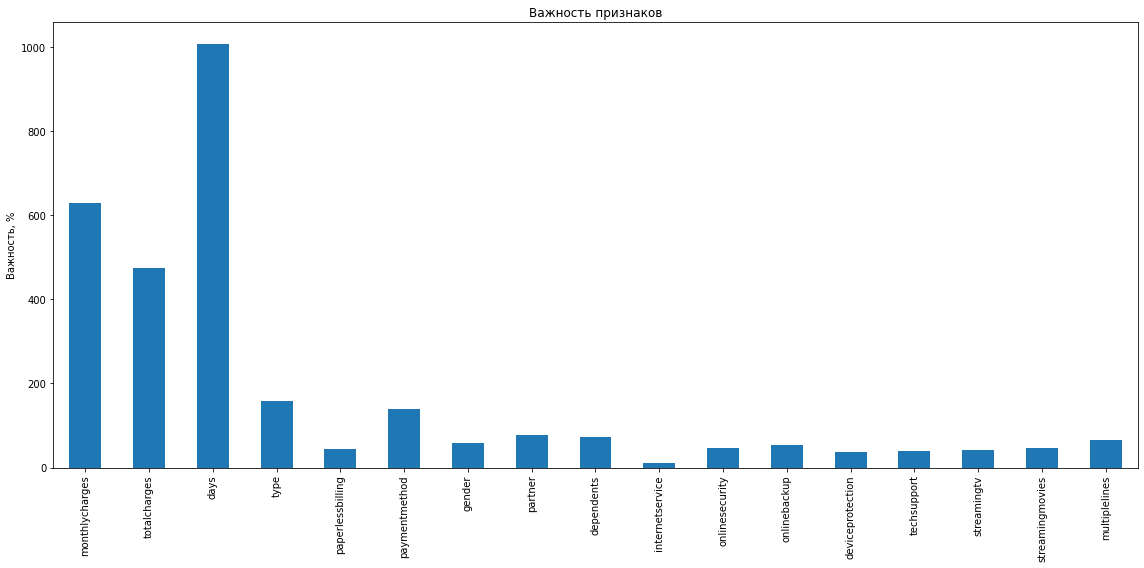

In [77]:
feature_imp = grid_lgbm.best_estimator_.feature_importances_
cat_imp = pd.Series(feature_imp,
                    features_train_2.columns)
fig, ax = plt.subplots(figsize=(16, 8))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

## Выводы

В проекте необходимо было проанализировать отток клиентов и построить модель, которая поможет предсказать уход клиента. Я провела исследовательский анализ данных, сделала еще один признак - количество дней по контракту. Далее разделила датасет на выборки, масшталировала признаки и обучила 3 модели, предсказывающие уход клиента: линейную регрессию, случайный лес и lightGBM. В результате лучшей моделью оказалась модель lightGBM, на тестовой выборке она показала результат auc-roc = 0.87. После обучения модели посмотрела на то, какие признаки оказались наиболее значимыми для модели. Ими оказались как раз созданный признак - количество дней по контракту, а также ежемесячные траты на услуги и общие траты за весь период контракта. Остальные признаки существенного влияния на модель не оказали. Анализ данных на первом этапе показал примерно такую же картину по важности признаков, не считая нового признака days. 

## Отчет

В отчёте ответьте на вопросы: <br>
Какие пункты плана были выполнены, а какие — нет. Почему? <br>
Какие трудности возникли и как вы их преодолели? <br>
Какие ключевые шаги в решении задачи вы выделили? <br>
Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена? <br>
Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество? <br>

1. На мой взгляд я выполнила все пункты своего изначального плана: обработка и анализ данных, разделение на выборки и кодирование данных, обучение моделей и подбор гиперпараметров, чтобы достичь необходимых значений метрики auc-roc, протестировать модель на тестовой выборке и достичь нужного значений метрики auc-roc и там. <br> 
Кроме того по ходу выполнения работы выяснились дополнительные требования в виде выявления дополнительных признаков и оценки важности всех признаков для модели. Всё это было сделано. <br> 
2. В ходе выполенения работы были трудности с кодированием данных. Для меня было открытием, что метод OHE непригоден для моделей случайного леса и lightGBM. Также было непонятно, как выявлять важные характеристики. Но благодаря тимлиду удалось справиться со всеми трудностями. <br>
3. Ключевые шаги это по сути все пункты из плана: обработка и анализ данных, разделение на выборки и кодирование данных, обучение моделей и подбор гиперпараметров. <br>
4. Во всех моделях использовались все изначальные признаки, кроме 'customerid', 'begindate', 'enddate', которые были удалены, как неинформативные. Плюс добавился признак - количество дней по контракту 'days'. Все признаки были приведены к нужному типу данных и обработаны кодировщиками. Количественные - StandardScaler, категориальные - для линейной регрессии OHE, для моделей случайног леса и lightGBM OrdinalEncoder. <br>
5. Лучшей моделью по результам обучения оказалась модель lightGBM с результатом метрики auc-roc = 0.85. По результатам тестирования = 0.87. Модель обучалась с перебором гиперпараметров param_grid = {'max_depth': [2, 6, 12], 'n_estimators': [20, 50, 100]}.